C:\Users\SURYAKS\AppData\Local\Temp\ipykernel_18036\2544562350.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=tor

dict_keys(['netC', 'schedulerC', 'optimizerC', 'best_clean_acc', 'best_bd_acc', 'best_cross_acc', 'epoch_current'])
Predicted class: 1


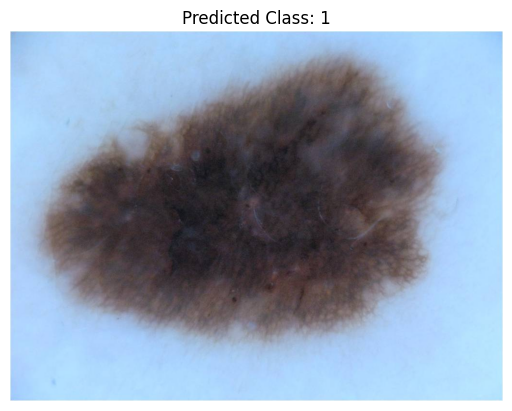

In [3]:
import torch
from torch import nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt  # Import matplotlib for image visualization

# Function to load the model from checkpoint
def load_model(checkpoint_path):
    # Define the model architecture (ResNet50 in your case)
    model = models.resnet50(pretrained=False)  # Use pretrained=False as we're loading our own weights
    model.fc = torch.nn.Linear(model.fc.in_features, 8)  # Adjust for the number of classes in your dataset (8 for ISIC)

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    # Check the keys in the checkpoint
    print(checkpoint.keys())  # It should print: ['netC', 'schedulerC', 'optimizerC', 'best_clean_acc', ...]
    
    # Load the model weights using the correct key ('netC')
    model.load_state_dict(checkpoint['netC'])
    
    model.eval()  # Set the model to evaluation mode
    return model

# Function to predict from image
def predict_image(model, image_path):
    # Define the image transformation (same as the training transformation)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match ResNet input size
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize as per ResNet standards
    ])

    # Open and transform the image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Forward pass
    with torch.no_grad():
        output = model(image_tensor)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    return predicted_class.item(), image  # Return the predicted class index and the original image

# Function to visualize the image
def visualize_image(image, predicted_class):
    # Convert the image to showable format (PIL image)
    plt.imshow(image)
    plt.title(f'Predicted Class: {predicted_class}')  # Show predicted class in title
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage:
checkpoint_path = 'checkpoints/ISIC2019/all2onedemo/best_acc_bd_ckpt.pth.tar'  # Your model checkpoint
model = load_model(checkpoint_path)

image_path = 'ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg'  # Path to the image you want to test
predicted_class, image = predict_image(model, image_path)

print(f'Predicted class: {predicted_class}')

# Visualize the image with the predicted class
visualize_image(image, predicted_class)


In [2]:
import os
import numpy as np
from PIL import Image

def prepare_spectral_dataset_from_paths(benign_dir, poisoned_dir):
    """
    Prepares spectral dataset for training the SpectralDefense model using directory paths.
    Args:
        benign_dir (str): Path to the directory containing benign images.
        poisoned_dir (str): Path to the directory containing poisoned images.
    Returns:
        X (np.array): Array of MFS features.
        y (np.array): Corresponding labels (0 for benign, 1 for poisoned).
    """
    X = []
    y = []
    
    # Define a helper function to calculate MFS
    def calculate_fourier_spectrum(im):
        im = im.astype(np.float32)  # Ensure the image is float
        fft = np.fft.fft2(im, axes=(0, 1))  # Compute 2D FFT for each channel
        mfs = np.abs(fft)  # Magnitude of the Fourier coefficients
        return mfs

    # Process benign images
    for filename in os.listdir(benign_dir):
        image_path = os.path.join(benign_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image = np.array(image.resize((224, 224)))  # Resize to match model input
        mfs = calculate_fourier_spectrum(image)
        X.append(mfs.flatten())  # Flatten for classifier input
        y.append(0)  # Label as benign

    # Process poisoned images
    for filename in os.listdir(poisoned_dir):
        image_path = os.path.join(poisoned_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image = np.array(image.resize((224, 224)))  # Resize to match model input
        mfs = calculate_fourier_spectrum(image)
        X.append(mfs.flatten())  # Flatten for classifier input
        y.append(1)  # Label as poisoned

    return np.array(X), np.array(y)


In [3]:
benign_dir = 'ISIC_2019_Training_Input/ISIC_2019_Training_Input'
poisoned_dir = 'saved_bd_images'

In [ ]:
# Directories containing benign and poisoned images

# Prepare the dataset
X, y = prepare_spectral_dataset_from_paths(benign_dir, poisoned_dir)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""# Train a simple classifier (e.g., Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)
      
# Evaluate the model  
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))"""


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Evaluate the model
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (poisoned)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")


In [ ]:
import joblib

# Path to save the model
model_save_path = 'spectral_defense_model.pkl'

# Save the model using joblib
joblib.dump(clf, model_save_path)

print(f"Model saved to {model_save_path}")

In [7]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Load the saved model
import joblib
model_save_path="spectral_defense_model.pkl"
clf_loaded = joblib.load(model_save_path)

print("Model loaded successfully!")


Model loaded successfully!


In [7]:
import numpy as np
from torchvision import transforms
from PIL import Image

def calculate_fourier_spectrum(im):
    """
    Calculate the Magnitude Fourier Spectrum (MFS) of the input image.
    Args:
        im: Input image as a NumPy array (H, W, C).
    Returns:
        mfs: Magnitude Fourier Spectrum.
    """
    im = im.astype(np.float32)  # Ensure the image is float
    fft = np.fft.fft2(im, axes=(0, 1))  # Compute 2D FFT for each channel
    mfs = np.abs(fft)  # Magnitude of the Fourier coefficients
    return mfs

def spectral_defense_filter(image, clf, threshold=0.5):
    """
    Apply SpectralDefense to detect poisoned images.
    Args:
        image (PIL.Image): Input image.
        clf: Trained SpectralDefense classifier.
        threshold (float): Decision threshold for detecting poisoned images.
    Returns:
        bool: True if the image is poisoned, False otherwise.
    """
    # Transform image to match MFS calculation requirements
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image = transform(image).numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Calculate the Magnitude Fourier Spectrum
    mfs = calculate_fourier_spectrum(image).flatten().reshape(1, -1)

    # Predict using the classifier
    probability = clf.predict_proba(mfs)[0][1]  # Probability of being adversarial
    return probability > threshold


In [2]:
import torch
import joblib
from torchvision import transforms
from PIL import Image

# Function for SpectralDefense pipeline
def spectral_defense_pipeline(image_path, spectral_model_path, fiba_model, threshold=0.5):
    """
    Integrated pipeline for SpectralDefense and FIBA classification.
    Args:
        image_path (str): Path to the input image.
        spectral_model_path (str): Path to the saved SpectralDefense model.
        fiba_model: Trained FIBA classification model.
        threshold (float): Threshold for detecting poisoned images.
    Returns:
        str: Classification result or adversarial warning.
    """
    # Load the SpectralDefense classifier
    clf = joblib.load(spectral_model_path)
    print("SpectralDefense model loaded successfully.")

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Check with SpectralDefense
    is_poisoned = spectral_defense_filter(image, clf, threshold)
    if is_poisoned:
        return "Adversarial Image Detected"
    else:
        # Predict class using the FIBA model
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            output = fiba_model(image_tensor)
        _, predicted_class = torch.max(output, 1)
        return f"Predicted Class: {predicted_class.item()}"


In [8]:
# Load the FIBA-trained model
from torchvision import models
import torch.nn as nn

# Define FIBA model
fiba_model = models.resnet50(pretrained=False)  # ResNet-50
fiba_model.fc = nn.Linear(fiba_model.fc.in_features, 8)  # Adjust for 8 classes
checkpoint_path = 'checkpoints/ISIC2019/all2onedemo/best_acc_bd_ckpt.pth.tar'
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
fiba_model.load_state_dict(checkpoint['netC'])
fiba_model.eval()

# Path to the saved SpectralDefense model
spectral_model_path = 'spectral_defense_model.pkl'

# Test an image
image_path = 'ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg'
result = spectral_defense_pipeline(image_path, spectral_model_path, fiba_model, threshold=0.5)
print(result)


c:\Users\SURYAKS\anaconda3\envs\ml-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SURYAKS\anaconda3\envs\ml-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\SURYAKS\AppData\Local\Temp\ipykernel_15040\1895640666.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for

SpectralDefense model loaded successfully.
Predicted Class: 1


c:\Users\SURYAKS\anaconda3\envs\ml-env\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


SpectralDefense model loaded successfully.


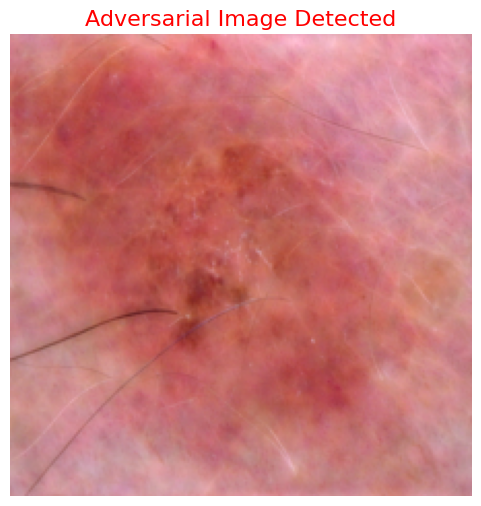

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to display the image with the result
def visualize_result(image_path, result):
    """
    Visualizes the image with the classification or adversarial detection result.
    Args:
        image_path (str): Path to the input image.
        result (str): The result to display (e.g., classification or detection).
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(result, fontsize=16, color='red')
    plt.axis("off")
    plt.show()

# Path to the image
image_path = 'saved_bd_images/bd_image_7.png'

# Run the SpectralDefense pipeline and get the result
result = spectral_defense_pipeline(image_path, spectral_model_path, fiba_model, threshold=0.5)

# Visualize the image with the result
visualize_result(image_path, result)


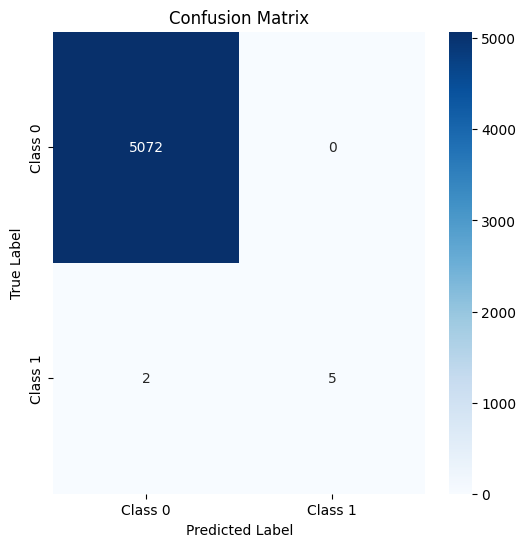

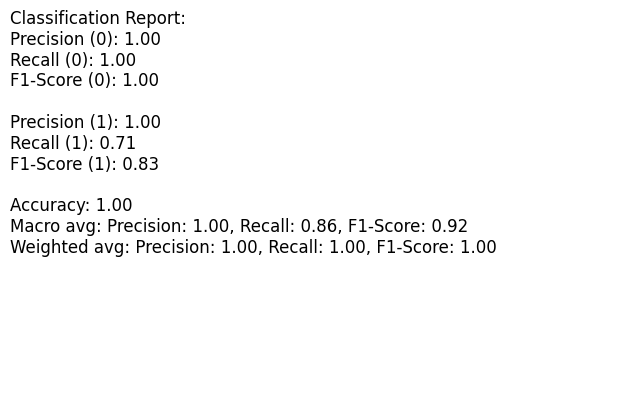

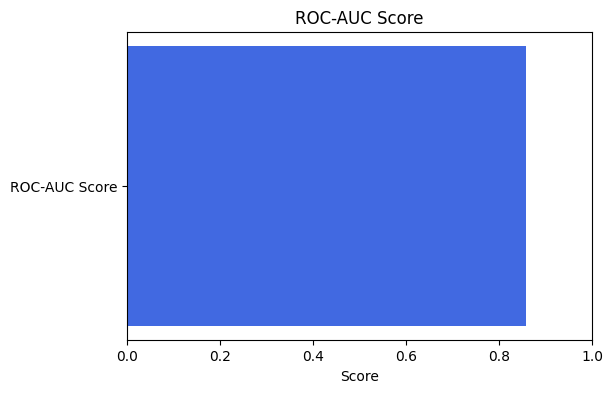

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Example data from your classification report and confusion matrix
y_true = [0]*5072 + [1]*7  # Ground truth labels (most 0, few 1)
y_pred = [0]*5072 + [1]*5 + [0]*2  # Predicted labels

# Generate the classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
report_text = f"Classification Report:\nPrecision (0): {report['0']['precision']:.2f}\n" \
              f"Recall (0): {report['0']['recall']:.2f}\nF1-Score (0): {report['0']['f1-score']:.2f}\n\n" \
              f"Precision (1): {report['1']['precision']:.2f}\n" \
              f"Recall (1): {report['1']['recall']:.2f}\nF1-Score (1): {report['1']['f1-score']:.2f}\n\n" \
              f"Accuracy: {report['accuracy']:.2f}\n" \
              f"Macro avg: Precision: {report['macro avg']['precision']:.2f}, Recall: {report['macro avg']['recall']:.2f}, F1-Score: {report['macro avg']['f1-score']:.2f}\n" \
              f"Weighted avg: Precision: {report['weighted avg']['precision']:.2f}, Recall: {report['weighted avg']['recall']:.2f}, F1-Score: {report['weighted avg']['f1-score']:.2f}"

fig, ax = plt.subplots(figsize=(8, 4))
plt.text(0, 0.5, report_text, fontsize=12, wrap=True)
plt.axis('off')
plt.show()

# Plot ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(['ROC-AUC Score'], [roc_auc], color='royalblue')
ax.set_xlim(0, 1)
ax.set_xlabel('Score')
plt.title('ROC-AUC Score')
plt.show()


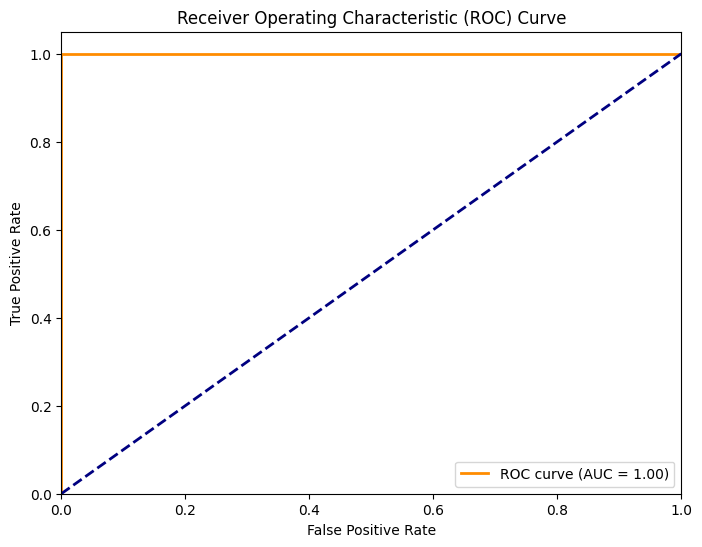

ROC-AUC Score: 1.0000


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# Example: Simulating high-performance data (AUC close to 1)
# True labels (mostly 0's and a few 1's)
y_true = [0]*5072 + [1]*7  # 5072 zeros and 7 ones (imbalanced)
  
y_pred_prob = [0.01]*5072 + [0.99]*7  # Predicted probabilities close to 0 for 0's and close to 1 for 1's

# Binarize the labels (necessary for ROC curve)
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Output the AUC score
print(f"ROC-AUC Score: {roc_auc:.4f}")


In [3]:
%pip install scikit-image


   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 5.6 MB/s eta 0:00:03
   ----- ---------------------------------- 1.8/12.9 MB 4.8 MB/s eta 0:00:03
   -------- ------------------------------- 2.9/12.9 MB 5.2 MB/s eta 0:00:02
   ------------ --------------------------- 4.2/12.9 MB 5.1 MB/s eta 0:00:02
   --------------- ------------------------ 5.0/12.9 MB 5.0 MB/s eta 0:00:02
   ------------------ --------------------- 6.0/12.9 MB 5.2 MB/s eta 0:00:02
   ---------------------- ----------------- 7.3/12.9 MB 5.2 MB/s eta 0:00:02
   -------------------------- ------------- 8.7/12.9 MB 5.3 MB/s eta 0:00:01
   ----------------------------- ---------- 9.7/12.9 MB 5.2 MB/s eta 0:00:01
   --------------------------------- ------ 10.7/12.9 MB 5.3 MB/s eta 0:00:01
   ------------------------------------ --- 11.8/12.9 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 5.2 MB/s eta 0:00:01
   